#  Homework week 12
## MBIO612
### Gabrielle Martineau

In [5]:
#Set working directory
setwd("~/U_of_H/FALL_2021/MBIO612/Week_11")

In [2]:
#load necessary packages
install.packages("leaps")

Installing package into 'C:/Users/Martine/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'leaps' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Martine\AppData\Local\Temp\RtmpMbFGdB\downloaded_packages


In [3]:
#load necessary libraries
library(tidyverse)
library(dplyr)
library(MASS)
library(leaps)
library(stats)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.1 --
v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'MASS' was built under R version 3.6.3"
Attaching pack

## Load the data

In [7]:
#load the data
#Retrieve data set saved from practical week 9 for which we computed richness of RIKZ data set
RIKZ_richness <- read.csv("RIKZ_with_diversity.csv", header=TRUE)

#specificy which columns of the data set are species VS predictors
species_cols = 1:76

#creat subset of the data that only has the predictors
survey_data_richness = RIKZ_richness[,-species_cols]
head(survey_data_richness, n=2)

week,angle1,angle2,exposure,salinity,temperature,NAP,penetrability,grainsize,humus,chalk,sorting1,Beach,diversity_per_sample
1,32,96,10,29.4,17.5,0.045,253.9,222.5,0.05,2.05,69.83,1,11
1,62,96,10,29.4,17.5,-1.036,226.9,200.0,0.30,2.50,59.00,1,10


## Validation set approach

In [13]:
### Split observations between training and test data sets##

#create a training vector of values
set.seed (13)
train <- sample (c(TRUE , FALSE), nrow (survey_data_richness),
                   replace = TRUE)
test <- (!train)

In [23]:
#compute validation set error for each model of each size for training data set
#I have set a maximum subset size of 13 (max amount of parameters in our table)
regfit.best <- regsubsets (diversity_per_sample ∼ ., data = survey_data_richness [train , ], nvmax = 13)

#make a model matrix to test the data
test.mat <- model.matrix (diversity_per_sample ∼ ., data = survey_data_richness [test , ])

In [24]:
#run a loop to extract coefficients from the training data for the best model of each size
#multiply them by the appropriate matrix column and compute MSE

val.errors <- rep (NA, 13)
for (i in 1:13) {
  coefi <- coef (regfit.best , id = i)
  pred <- test.mat[, names (coefi)] %*% coefi
  val.errors[i] <- mean ((survey_data_richness$diversity_per_sample[test] - pred)^2)
}
val.errors

[1] 16.984008 21.887002 15.006091 11.424465 11.068733  7.852105  7.792069
 [8]  7.951756  7.748305  7.805627  8.059401  8.044342  8.144100

In [25]:
#find the number of coefficients in the model that has the minimal error
which.min(val.errors)


#find the coefficient of the model that bests fits the data
coef(regfit.best, 9)

[1] 9

(Intercept)        angle1        angle2      exposure      salinity 
-78.483820670  -0.002902848   0.054261829  -0.409349252   2.373634093 
  temperature           NAP     grainsize         chalk         Beach 
  0.582487722  -3.223365086   0.035215144  -0.199839122   0.180137421

In [26]:
#find the best 9 variables model, this time, when using the entire data set
regfit.best <- regsubsets (diversity_per_sample ∼ ., data = survey_data_richness, nvmax = 13)
coef(regfit.best, 9)

(Intercept)          week        angle1        angle2   temperature 
-30.065579009   1.437976110  -0.008612402   0.081221990   1.720790887 
          NAP penetrability     grainsize         chalk         Beach 
 -2.729551342  -0.008974255   0.019672573  -0.124653647  -0.997844403

Here, we notice that the predictors and their coefficients for the model obtained with the full data are different than the ones with the training data set

In [27]:
#write our own predict function based on the code above
predict.regsubsets <- function (object , newdata , id, ...) {
  form <- as.formula(object$call[[2]])
  mat <- model.matrix (form , newdata)
  coefi <- coef (object , id = id)
  xvars <- names (coefi)
  mat[, xvars] %*% coefi
  }

## Cross-Validation

In [28]:
#Choose among models of diff sizes using cross-validation

#Create vector thta allocates each observation to one k-fold
k <- 10
n <- nrow (survey_data_richness)
set.seed (15)
folds <- sample ( rep(1:k, length = n))

In [29]:
#Create a matrix to store the results
cv.errors <- matrix (NA, k, 13,dimnames = list (NULL , paste (1:13)))

In [30]:
#create a foor-loop that computes cross-validation and MSE
#j is for every k-fold to be used as a test set and 
#i is for the number of variable in the model

for (j in 1:k) {
   best.fit <- regsubsets (diversity_per_sample∼ .,
                           data = survey_data_richness[folds!= j, ],nvmax = 13)
                          
   for (i in 1:13) {
     pred <- predict.regsubsets(best.fit ,survey_data_richness[folds == j, ], id = i)
     cv.errors[j, i] <- mean ((survey_data_richness$diversity_per_sample[folds == j] - pred)^2)
     }
}

In [31]:
#The previous step results in a matrix with MSE jth cross-validation fold for the best i-variable model

#compute the mean of cross-validation errors for each i-length model 
mean.cv.errors <- apply (cv.errors , 2, mean)
mean.cv.errors

1        2        3        4        5        6        7        8 
28.19854 10.73451 12.00331 14.54402 14.76029 15.46001 15.46707 16.03461 
       9       10       11       12       13 
15.26733 15.64845 15.65682 15.87772 16.02078

In [32]:
#determine how many parameters does the best model have?
which.min(mean.cv.errors)

2 
2

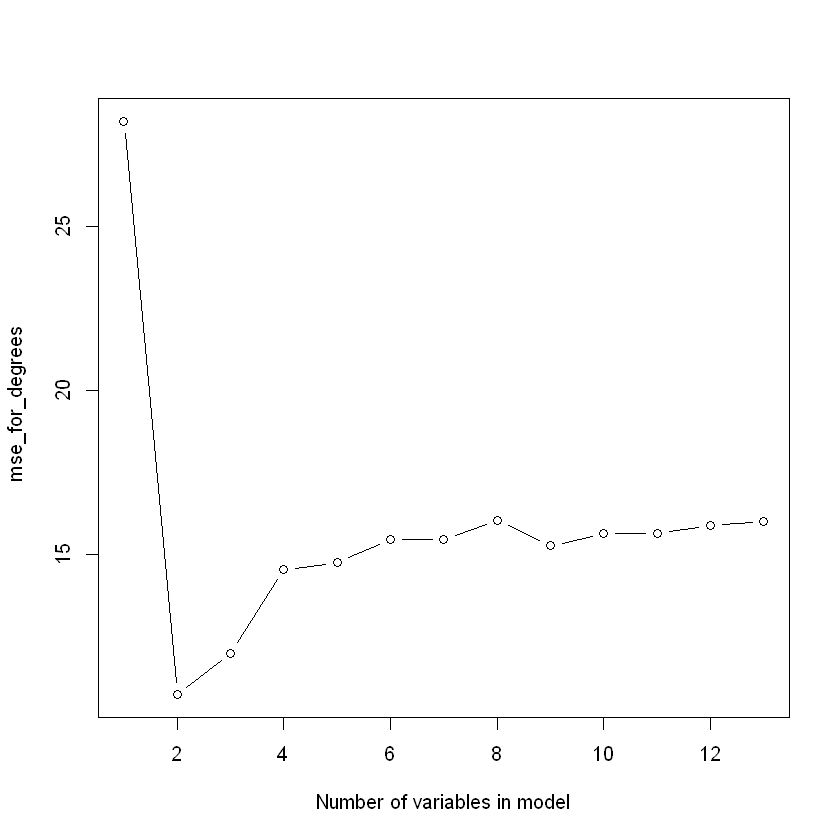

In [38]:
#According to the cross-validation method, the best model to predict and fit our data has 2 parameters. 
#This model also corresponds to the model with the lowest  MLE, as pictured in this graph.

par (mfrow = c(1, 1))
plot (mean.cv.errors , type = "b", ylab=" mse_for_degrees", xlab = "Number of variables in model")

In [39]:
#perform best subset selection on entire data set to identify the parameters and obtain the 2-variables model
reg.best <- regsubsets (diversity_per_sample ∼ ., data = survey_data_richness, nvmax = 13)
coef (reg.best , 2)

(Intercept)    exposure         NAP 
  37.290896   -2.998809   -2.725181

Here, the best model to predict the richness in this particular dataset according to 10-fold cross-validation has 2 predictors: exposure and NPP. 